#research question: can we predict building energy use based on the number of units in the building?

In [88]:
#start by importing needed packages and data from LL84 (building energy use) and MapPluto (Manhattan building lots)
import geopandas as gp
import pandas as pd
import csv
import urllib2
import os
import json
import pylab as pl
import numpy as np

%pylab inline

#read in data from LL84 - using Manhattan buildings to keep data set small; import with pandas or geopandas

Populating the interactive namespace from numpy and matplotlib


In [89]:
url = 'https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv?accessType=DOWNLOAD'
response = urllib2.urlopen(url)
nrg = gp.GeoDataFrame.from_csv(response)
#nrg = gp.GeoDataFrame.from_csv("Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv")
print nrg.columns

Index([u'NYC Borough, Block, and Lot (BBL)', u'Co-reported BBL Status',
       u'BBLs Co-reported',
       u'Reported NYC Building Identificaiton Numbers (BINs)',
       u'Street Number', u'Street Name', u'Borough', u'Zip Code',
       u'DOF Benchmarking Submission Status', u'Site EUI(kBtu/ft2)',
       u'Weather Normalized Site EUI(kBtu/ft2)', u'Source EUI(kBtu/ft2)',
       u'Weather Normalized Source EUI(kBtu/ft2)',
       u'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       u'Automatic Water Benchmarking Eligible', u'Reported Water Method',
       u'ENERGY STAR Score', u'Total GHG Emissions(MtCO2e)',
       u'Direct GHG Emissions(MtCO2e)', u'Indirect GHG Emissions(MtCO2e)',
       u'Reported Property Floor Area (Building(s)) (ft²)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       u'Primary Property Type - Self Selected', u'DOF Number of Buildings'],
      dtype='object')


In [90]:
#rename columns in the LL84 dataframe for easier use later on and to enable joining with MapPluto data on BBL column
nrg.columns = ['BBL', 'BBL_status', 'Co_reported', 'BINs', 'Number', 'Street', 'Borough', 'Zip', 'Benchmark_status', 'EUI', 'Weather_EUI','Source_EUI','Weather_Source_EUI', 'Water', 'Water2', 'Water3', 'Energy_Star', 'GHG_total', 'GHG_direct', 'GHG_indirect', 'Floor_area', 'Total_floor_area', 'Prop_type', 'Number_buildings']
print nrg.columns

Index([u'BBL', u'BBL_status', u'Co_reported', u'BINs', u'Number', u'Street',
       u'Borough', u'Zip', u'Benchmark_status', u'EUI', u'Weather_EUI',
       u'Source_EUI', u'Weather_Source_EUI', u'Water', u'Water2', u'Water3',
       u'Energy_Star', u'GHG_total', u'GHG_direct', u'GHG_indirect',
       u'Floor_area', u'Total_floor_area', u'Prop_type', u'Number_buildings'],
      dtype='object')


In [91]:
#note that MapPluto columns have better labels that do not require immediate renaming for later use
bsize = gp.GeoDataFrame.from_file("Manhattan/MNMapPLUTO.shp")
print bsize.columns

Index([    u'APPBBL',    u'APPDate',    u'Address', u'AllZoning1',
       u'AllZoning2', u'AreaSource', u'AssessLand',  u'AssessTot',
              u'BBL',   u'BldgArea',  u'BldgClass',  u'BldgDepth',
        u'BldgFront',      u'Block',   u'BoroCode',    u'Borough',
         u'BsmtCode',  u'BuiltCode',   u'BuiltFAR',     u'CB2010',
               u'CD',     u'CT2010',    u'ComArea',    u'CommFAR',
          u'CondoNo',    u'Council',  u'EDesigNum',  u'Easements',
       u'ExemptLand',  u'ExemptTot',        u'Ext',   u'FacilFAR',
       u'FactryArea',   u'FireComp', u'GarageArea', u'HealthArea',
         u'HistDist', u'IrrLotCode',    u'LandUse',   u'Landmark',
              u'Lot',    u'LotArea',   u'LotDepth',   u'LotFront',
          u'LotType',  u'LtdHeight', u'MAPPLUTO_F',   u'NumBldgs',
        u'NumFloors', u'OfficeArea',  u'OtherArea',   u'Overlay1',
         u'Overlay2',  u'OwnerName',  u'OwnerType', u'PLUTOMapID',
       u'PolicePrct',   u'ProxCode',    u'ResArea',   u'ResidF

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x132abeed0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10c369bd0>]], dtype=object)

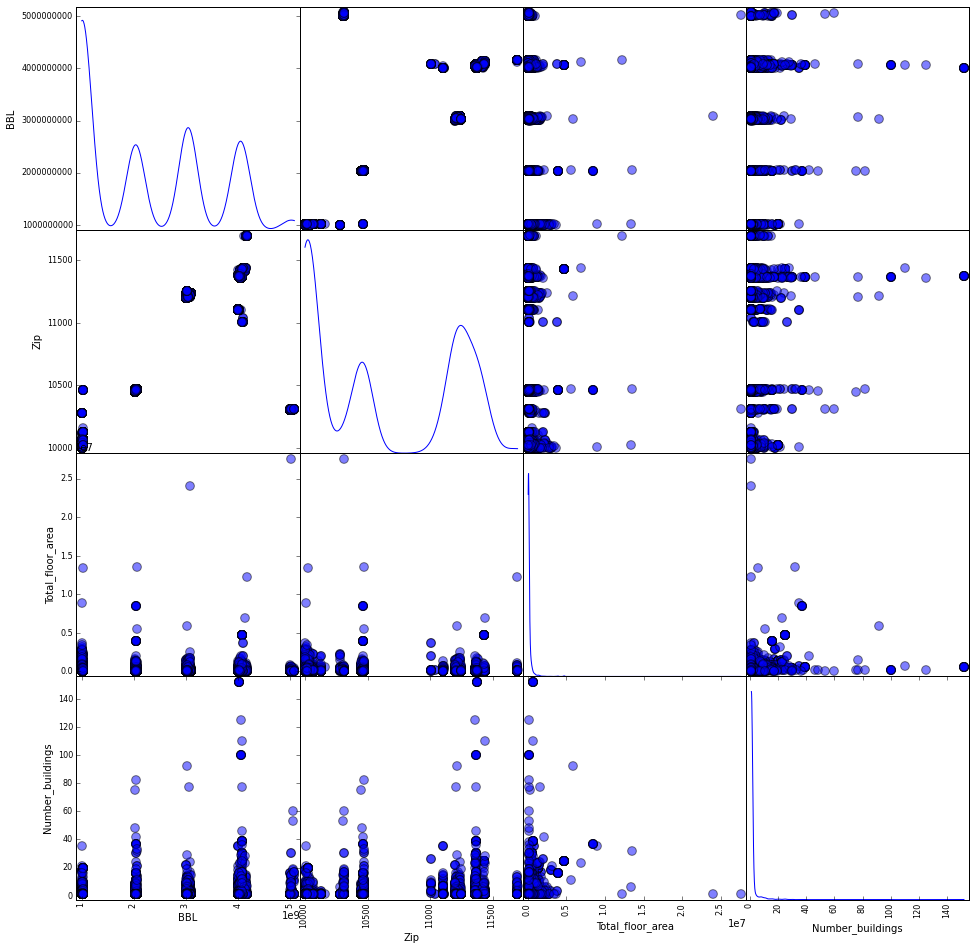

In [92]:
#use pandas for exploratory scatterplots that shows correlations, structures etc. Immediate patterns not relevant due in large part to data structure
from pandas.tools.plotting import scatter_matrix
scatter_matrix (nrg, s=300, figsize=(16, 16), diagonal='kde')

In [93]:
#function to convert non-float data to floats; done in 2 steps - identifying data that is convertable to floats through true/false boolean array
#then vectorizing, replacing non-relevant cells with NaN values, and converting all remaining data to floats
def canconvert(mydata):
    try :
        float(mydata)
        return True
    except ValueError:
        return False

convert = np.vectorize(canconvert)

In [94]:
#index and convert data necessary columns 

index_BBL = convert(nrg['BBL'])
nrg['BBL'][~index_BBL] = float('NaN')
nrg['BBL'] = [str(x) for x in nrg['BBL']]

index_EUI = convert(nrg['EUI'])
nrg['EUI'][~index_EUI] = float('NaN')
nrg['EUI'] = [float(x) for x in nrg['EUI']]

index_TFA = convert(nrg['Total_floor_area'])
nrg['Total_floor_area'][~index_TFA] = float('NaN')
nrg['Total_floor_area'] = [float(x) for x in nrg['Total_floor_area']]

index_PBBL = convert(bsize['BBL'])
bsize['BBL'][~index_PBBL] = float('NaN')
bsize['BBL'] = [str(x) for x in bsize['BBL']]

index_units = convert(bsize['UnitsTotal'])
bsize['UnitsTotal'][~index_units] = float('NaN')
bsize['UnitsTotal'] = [float(x) for x in bsize['UnitsTotal']]

#test
#print bsize['UnitsTotal']

#test data type
#print nrg['EUI'].astype(float)

/Users/rachelcohen/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rachelcohen/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rachelcohen/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rachelcohen/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:16: 

In [95]:
#merge data and test length to ensure rows maintained
all_data = pd.merge(nrg,bsize,on=['BBL'],how='inner')
len(all_data.BBL)

6545

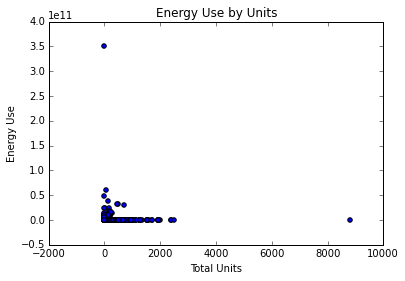

In [96]:
#data gives energy intensity (EUI - use per sq ft) as well as total building floor area - we need to multiply the 2 as
#a new column in the joined dataframe to find total building energy use

all_data.energy = []
all_data.energy = all_data.EUI*all_data.Total_floor_area.values

index_energy = convert(all_data.energy)
all_data.energy[~index_energy] = float('NaN')
all_data.energy = [float(x) for x in all_data.energy]
#print all_data.energy

y = all_data.energy
#print y

#scatter plot of total energy use (independent on y) against building units (dependent on x)
pl.scatter(all_data.UnitsTotal, y)
pl.xlabel('Total Units')
pl.ylabel('Energy Use')
pl.title('Energy Use by Units')

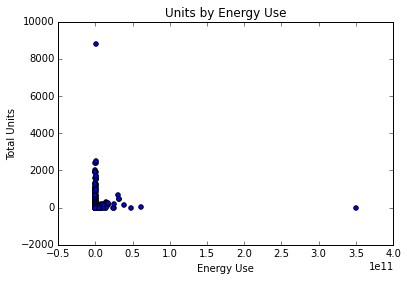

In [97]:
#flip variables to plot units by energy use instead

pl.scatter(y, all_data.UnitsTotal)
pl.legend(bbox_to_anchor=(1, 1))
pl.xlabel('Energy Use')
pl.ylabel('Total Units')
pl.title('Units by Energy Use')

#because of the number of 0 energy use buildings, scatter plots do not reveal much information

In [98]:
#to look for more useful scatter plots, I first tried plotting log units against log energy use (in both directions)

In [99]:
logy = np.log(all_data.energy, dtype='float64')
logx = np.log(all_data.UnitsTotal, dtype='float64')

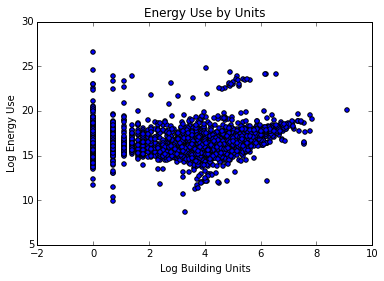

In [100]:
pl.scatter(logx, logy)
pl.xlabel('Log Building Units')
pl.ylabel('Log Energy Use')
pl.title('Energy Use by Units')

#This is the most revealing chart so far that begins to answer our research question.  Plotting log energy use against log building units, ignoring (likely misreported) buildings with fewer than 1 unit, there appears to be a positive correlation between building units and energy use. It also looks like there might be 2 clusters of buildings - "lower energy use" and "higher energy use" buildings, each with similar unit numbers but different energy use patterns.

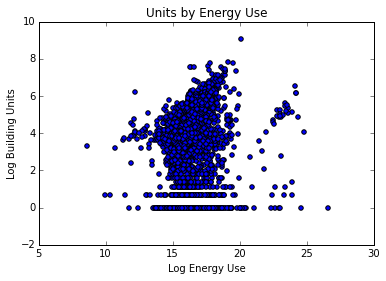

In [101]:
pl.scatter(logy, logx)
pl.ylabel('Log Building Units')
pl.xlabel('Log Energy Use')
pl.title('Units by Energy Use')

In [102]:
#for better results, limit the data set to buildings that reported positive energy use and unit numbers
all_data = all_data[all_data.EUI>1]
all_data = all_data[all_data.UnitsTotal>=1][all_data.UnitsTotal<=500]
len(all_data)

/Users/rachelcohen/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:1825: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


4879

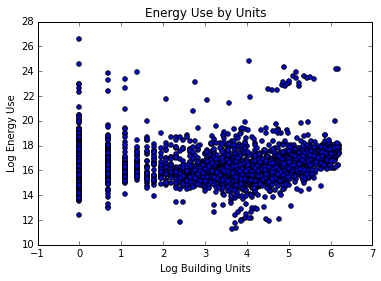

In [103]:
all_data.energy = []
all_data.energy = all_data.EUI*all_data.Total_floor_area.values
#print all_data.energy

index_energy = convert(all_data.energy)
all_data.energy[~index_energy] = float('NaN')
all_data.energy = [float(x) for x in all_data.energy]
#print all_data.energy

logy = np.log(all_data.energy, dtype='float64')
logx = np.log(all_data.UnitsTotal, dtype='float64')

pl.scatter(logx, logy)
set_xlim=(1,10)
set_ylim=(0, 30)
pl.xlabel('Log Building Units')
pl.ylabel('Log Energy Use')
pl.title('Energy Use by Units')


In [104]:
#trend appears somewhat clearer in the chart above, and it appears that plotting energy use as the Y against
#building units as the X is the revealing potclearer than the plot below

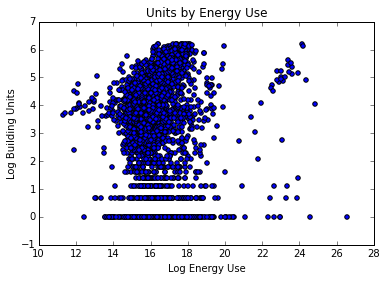

In [105]:
pl.scatter(logy, logx)
set_xlim=(1,30)
set_ylim=(0,10)
pl.ylabel('Log Building Units')
pl.xlabel('Log Energy Use')
pl.title('Units by Energy Use')

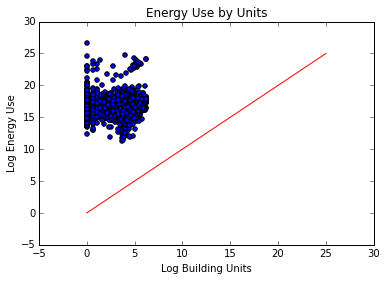

In [106]:
#next try fitting a line to the better loglog plot:
pl.scatter(logx, logy)
set_xlim=(1,10)
set_ylim=(0,30)
pl.xlabel('Log Building Units')
pl.ylabel('Log Energy Use')
pl.title('Energy Use by Units')
x = np.arange(0,26,1)
y = np.arange(0,26,1)
pl.plot(x, y, color='red')
#not very revealing!

In [107]:
#first ran regression of building units against energy intensity - found a p value of .14 meaning that energy intensity is not correlated to units

In [108]:
import scipy as sc
sc.stats.linregress(np.log10(all_data['UnitsTotal']), np.log10(all_data['EUI']))

(-0.02995505823020736,
 1.9698555443659747,
 -0.055025798831621876,
 0.00012032067998076172,
 0.0077833928321667896)

#here is the ultimate regression: the OLS model for energy use as a factor of building units shows a significant relationship (p = 0.00). The positive coefficient means that, as the total number of units in the building increases, so does its energy use. This is a logical conclusion!

In [109]:
import statsmodels.api as sm
X = sm.add_constant(np.log10(all_data.energy))
#print X
model = sm.OLS(np.log10(all_data.UnitsTotal), X, missing='drop').fit() # ignores entires where x or y is NaN
print model.summary()

                            OLS Regression Results                            
Dep. Variable:             UnitsTotal   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     8.482
Date:                Sat, 17 Oct 2015   Prob (F-statistic):            0.00360
Time:                        09:34:43   Log-Likelihood:                -4546.1
No. Observations:                4528   AIC:                             9096.
Df Residuals:                    4526   BIC:                             9109.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          1.2553      0.136      9.224      0.0

#look at the fit summary: which is better?
#running regression again with variables flipped; shows a much stronger correlation (both higher t value and larger coefficient), meaning that the units in a building can be partially explained by its energy use

In [110]:
X = sm.add_constant(np.log10(all_data.UnitsTotal))
#print X
model = sm.OLS(np.log10(all_data.energy), X, missing='drop').fit() # ignores entires where x or y is NaN
print model.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     8.482
Date:                Sat, 17 Oct 2015   Prob (F-statistic):            0.00360
Time:                        09:34:43   Log-Likelihood:                -3368.7
No. Observations:                4528   AIC:                             6741.
Df Residuals:                    4526   BIC:                             6754.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.9918      0.020    343.447      0.0

In [111]:
all_data.energy = []
all_data.energy = all_data.EUI*all_data.Total_floor_area.values

x = np.log10(all_data.UnitsTotal)
y = np.log10(all_data.energy)

np.polyfit(x, y, 2)

array([ nan,  nan,  nan])

In [113]:
#since my total energy returned NaN data, I ran the second degree curve test with energy intensity instead. 

In [112]:
x = np.log10(all_data.UnitsTotal)
y = np.log10(all_data.EUI)

np.polyfit(x, y, 2)

array([ 0.07497086, -0.21979364,  2.04648341])

#you cannot do a likelihood-ratio test on this data since both arrays have the same dimensions